In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import matplotlib
from matplotlib.legend_handler import HandlerTuple
import wandb
import torch.nn as nn
import torchvision.transforms as tform
import torch.optim as optim
import aslxplane.perception.estimators as estimators
from aslxplane.utils.analysis_utils import get_episode_dict
import yaml
from torch.utils.data import Dataset, DataLoader
from tqdm import trange, tqdm
from PIL import Image
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'
%autoreload 2

## Load Data

In [3]:
data_dir = "../../Xplane-data-dir/xplane-asl-test/ood_cdc/"
label_file = "labels.csv"
exp_param_file = "params/experiment_params.yaml"
sim_param_file = "params/simulator_params.yaml"

In [4]:
with open(data_dir + sim_param_file) as file:
	simulator_params = yaml.load(file, Loader=yaml.FullLoader)
with open(data_dir + exp_param_file) as file:
	experiment_params = yaml.load(file, Loader=yaml.FullLoader)
df = pd.read_csv(data_dir + label_file)
episode_dict = get_episode_dict(df)
df[:5]


,image_filename,absolute_time_GMT_seconds,relative_time_seconds,distance_to_centerline_meters,distance_to_centerline_NORMALIZED,downtrack_position_meters,downtrack_position_NORMALIZED,heading_error_degrees,heading_error_NORMALIZED,speed_meters_per_second,period_of_day,cloud_type,image_corruption
0,MWH_Runway04_morning_overcast_0_0.png,64829.640625,0.000000,0.161543,0.016154,90.032112,3.019186,0.379623,0.012654,4.991572,0,4,0
1,MWH_Runway04_morning_overcast_0_1.png,64830.726562,1.085938,0.249996,0.025000,95.355647,3.197708,0.404815,0.013494,4.871608,0,4,0
2,MWH_Runway04_morning_overcast_0_2.png,64831.863281,2.222656,0.336375,0.033637,100.896462,3.383517,0.270354,0.009012,4.819515,0,4,0
3,MWH_Runway04_morning_overcast_0_3.png,64833.011719,3.371094,0.409556,0.040956,106.348472,3.566347,0.001979,0.000066,4.786612,0,4,0
4,MWH_Runway04_morning_overcast_0_4.png,64834.109375,4.468750,0.454961,0.045496,111.631497,3.743511,-0.286088,-0.009536,4.769649,0,4,0


In [5]:
model = estimators.TaxiNet(
    "../" + experiment_params["state_estimation"]["model_file"],
    experiment_params["logging"]["normalization"]
)

## Get Estimates For each Trajectory

In [6]:
# Ground Truth
ctes = [df.loc[v, "distance_to_centerline_meters"] for k,v in episode_dict.items()]
dps = [df.loc[v, "downtrack_position_meters"] for k,v in episode_dict.items()]
hes = [df.loc[v, "heading_error_degrees"] for k,v in episode_dict.items()]
time_step = simulator_params["simulator"]['time_step']
failure_times = [int(t / time_step) for t in experiment_params["ood"]["transient_time_range"]]


In [7]:
# taxinet estimates
images = [[Image.open(data_dir + df.loc[i, "image_filename"]) for i in v] for k, v in episode_dict.items()]
estimates = [[model.get_estimate(img) for img in imgs_ep] for imgs_ep in images]
estimates = [np.array(ests) for ests in estimates]

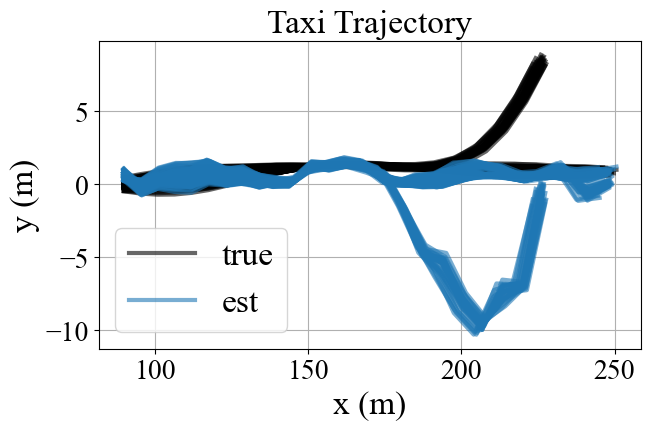

In [8]:
plt.figure(figsize=(7,4))
ax = plt.gca()
alpha=.6
for i, (cte, dp) in enumerate(zip(ctes, dps)):
    if i == 0:
        ax.plot(dp, cte, lw=3, color="black",alpha=alpha, label="true")
    else:
        ax.plot(dp, cte, lw=3, color="black",alpha=alpha)

for i, (ests, dp) in enumerate(zip(estimates, dps)):
    if i == 0:
        ax.plot(dp, ests[:,0], lw=3, color="tab:blue",alpha=alpha, label="est")
    else:
        ax.plot(dp, ests[:,0], lw=3, color="tab:blue",alpha=alpha)


ax.grid()
# ax.set_ylim(-15,15)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Taxi Trajectory")
ax.legend()

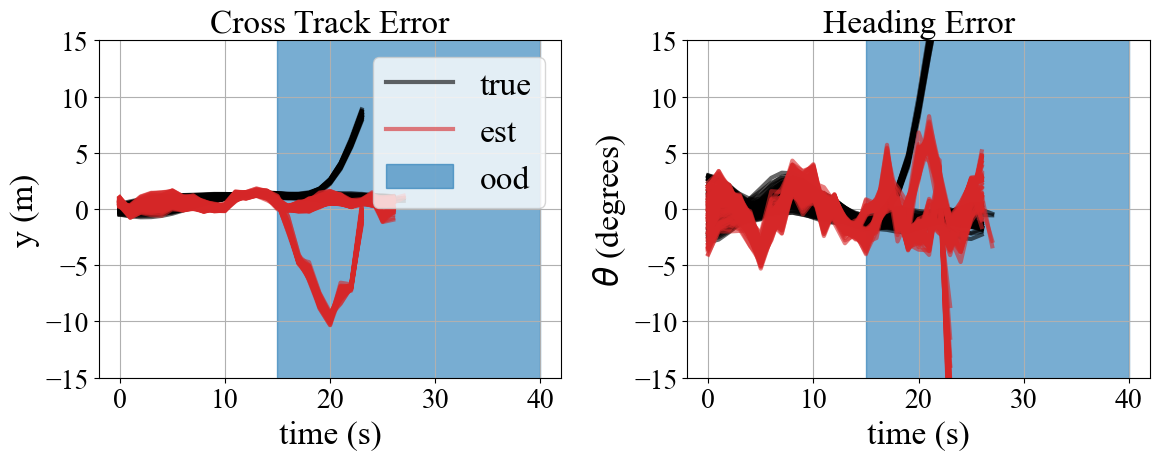

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
for i, (cte, he) in enumerate(zip(ctes, hes)):
    if i == 0:
        axs[0].plot(np.arange(len(cte)) * time_step, cte.to_numpy(), lw=3, color="black",alpha=alpha, label="true")
        axs[1].plot(np.arange(len(he)) * time_step, he.to_numpy(), lw=3, color="black",alpha=alpha, label="true")
    else:
        axs[0].plot(np.arange(len(cte)) * time_step, cte.to_numpy(), lw=3, color="black",alpha=alpha)
        axs[1].plot(np.arange(len(he)) * time_step, he.to_numpy(), lw=3, color="black",alpha=alpha)

for i, (ests, dp) in enumerate(zip(estimates, dps)):
    if i == 0:
        axs[0].plot(np.arange(ests.shape[0]) * time_step, ests[:,0], lw=3, color="tab:red",alpha=alpha, label="est")
        axs[1].plot(np.arange(ests.shape[0]) * time_step, ests[:,1], lw=3, color="tab:red",alpha=alpha, label="est")
    else:
        axs[0].plot(np.arange(ests.shape[0]) * time_step, ests[:,0], lw=3, color="tab:red",alpha=alpha)
        axs[1].plot(np.arange(ests.shape[0]) * time_step, ests[:,1], lw=3, color="tab:red",alpha=alpha)

axs[0].fill_between(failure_times, [-20, -20], [20,20],color="tab:blue", label="ood", alpha=alpha)
axs[0].grid()
axs[0].set_ylim(-15,15)
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel("y (m)")
axs[0].set_title("Cross Track Error")
axs[0].legend(loc="upper right")
axs[1].fill_between(failure_times, [-50, -50], [50,50] ,color="tab:blue", label="ood", alpha=alpha)
axs[1].set_ylim(-15,15)
axs[1].grid()
axs[1].set_title("Heading Error")
axs[1].set_ylabel(r"$\theta$ (degrees)")
axs[1].set_xlabel("time (s)")
plt.tight_layout()


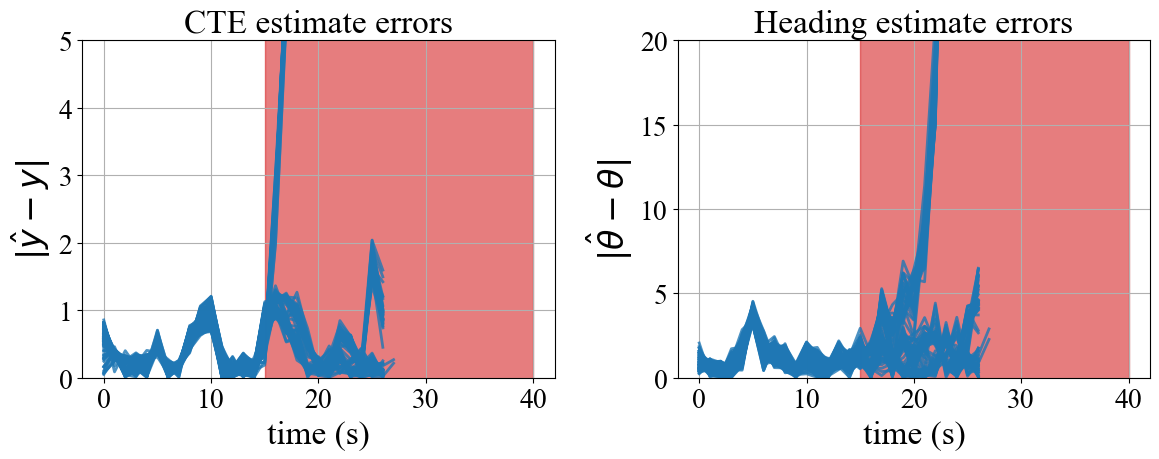

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

for cte, he, ests in zip(ctes, hes, estimates):
    axs[0].plot(np.abs(ests[:,0] - cte.to_numpy()), lw=2, color="tab:blue", alpha=.8)
    axs[1].plot(np.abs(ests[:,1] - he.to_numpy()), lw=2, color="tab:blue", alpha=.8)
axs[0].fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
axs[0].grid()
axs[0].set_ylim(0,5)
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel(r"$|\hat{y} - y|$")
axs[0].set_title("CTE estimate errors")
axs[1].grid()
axs[1].set_ylim(0,20)
axs[1].set_xlabel("time (s)")
axs[1].fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
axs[1].set_ylabel(r"$|\hat{\theta} - \theta|$")
axs[1].set_title("Heading estimate errors")
plt.tight_layout()

In [11]:
def plot_with_bars_qts(ax, ts, x, label, alpha=0.3, lw=2, linestyle="-", color="tab:blue"):
    q2 = np.quantile(x, 0.5, axis=1)
    q1 = np.quantile(x, 0.05, axis=1)
    q3 = np.quantile(x, 0.95, axis=1)
    # import pdb; pdb.set_trace()
    ax.fill_between(ts, q1, q3, alpha=alpha, color=color)
    ax.plot(ts, q2, linestyle, lw=lw, label=label, color=color)
    return q2

In [12]:
def array_formatting(items):
    max_length = np.max([it.shape[0] for it in items])
    output = np.ones((max_length, items[0].shape[1], len(items))) * np.NaN
    for i, it in enumerate(items):
        output[:it.shape[0], :it.shape[1], i] = it
    return output

In [13]:
format_estimates = array_formatting(estimates)
true_states = array_formatting([np.vstack((cte, he)).T for cte, he in zip(ctes, hes)])

In [14]:
true_states[10:,:,:].shape

(18, 2, 100)

(28, 2, 100)


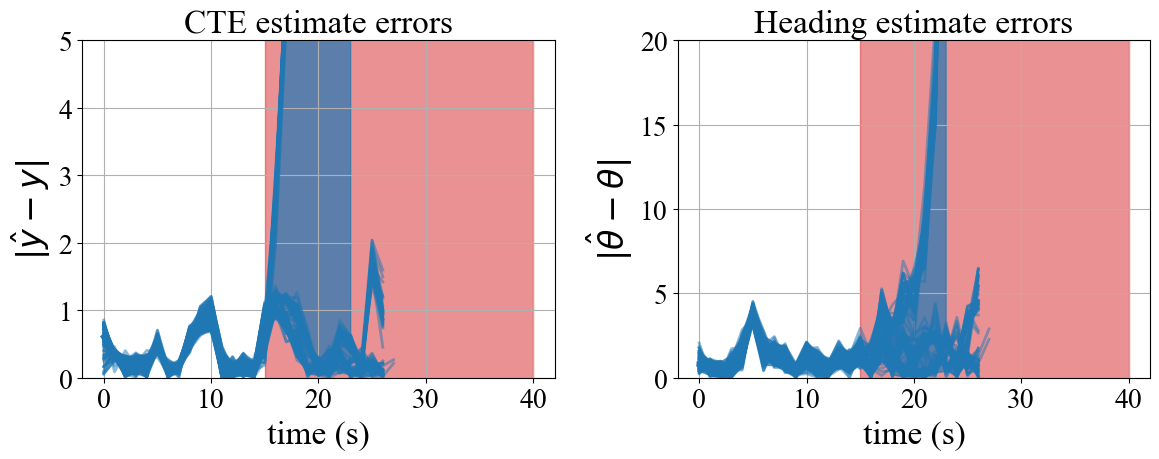

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
i = 0
diff = format_estimates[i:,:,:] - true_states[i:,:,:]
alpha=.5
print(diff.shape)
axs[0].fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
axs[0].grid()
axs[0].set_ylim(0,5)
axs[0].set_xlabel("time (s)")
axs[0].set_ylabel(r"$|\hat{y} - y|$")
axs[0].set_title("CTE estimate errors")
axs[1].grid()
axs[1].set_ylim(0,20)
axs[1].set_xlabel("time (s)")
axs[1].fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
axs[1].set_ylabel(r"$|\hat{\theta} - \theta|$")
axs[1].set_title("Heading estimate errors")
for cte, he, ests in zip(ctes, hes, estimates):
    axs[0].plot(np.abs(ests[:,0] - cte.to_numpy()), lw=2, color="tab:blue", alpha=alpha)
    axs[1].plot(np.abs(ests[:,1] - he.to_numpy()), lw=2, color="tab:blue", alpha=alpha)
plot_with_bars_qts(
    axs[0], 
    np.arange(diff.shape[0]) * time_step, 
    np.abs(diff[:,0,:]), 
    "errors",
    alpha=.7,
    lw=4
)
plot_with_bars_qts(
    axs[1], 
    np.arange(diff.shape[0]) * time_step, 
    np.abs(diff[:,1,:]), 
    "errors",
    alpha=.7,
    lw=4
)
plt.tight_layout()

In [16]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [17]:
def add_img(i, ax, q, offset_x=1, offset_y=1):
    ab = AnnotationBbox(OffsetImage(images[0][i], zoom=0.3), (i * time_step + offset_x, q[i] + offset_y), frameon=False)
    arrow_props = dict(facecolor='black', arrowstyle='->', linewidth=3)
    ax.annotate('', xy=(i * time_step, q[i]), xycoords='data', xytext=(i * time_step+ offset_x, q[i]+ offset_y), textcoords='data', arrowprops=arrow_props, fontsize=10)
    ax.add_artist(ab)


(28, 2, 100)


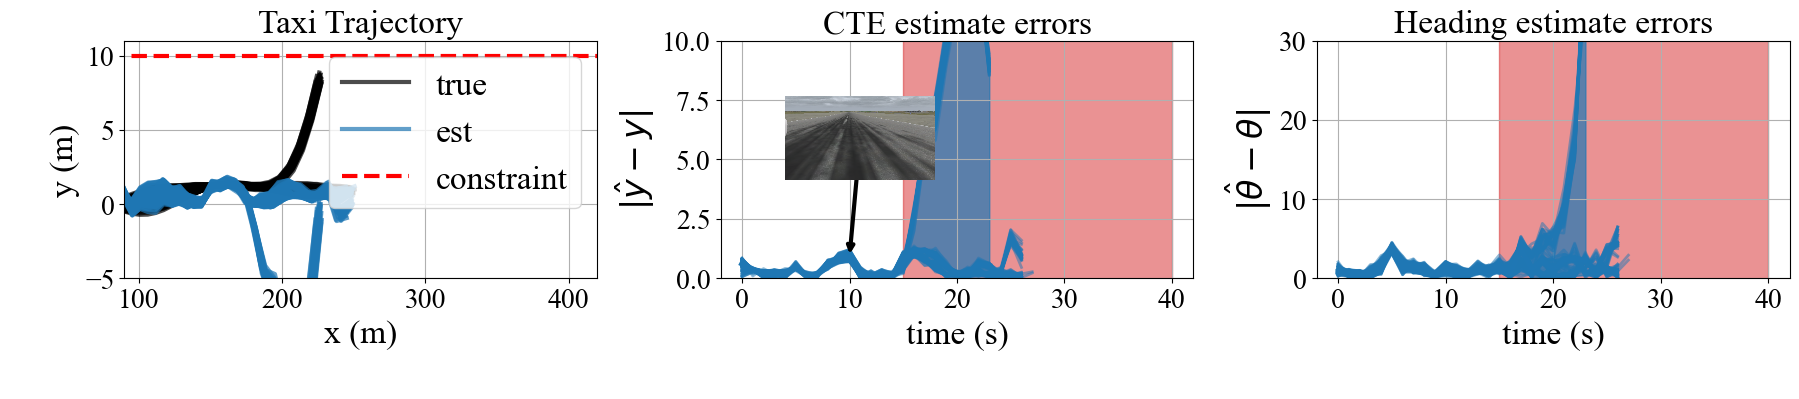

In [18]:
fig, axs = plt.subplots(1,3, figsize=(18,4))

alpha=.7
for i, (cte, dp) in enumerate(zip(ctes, dps)):
    if i == 0:
        axs[0].plot(dp, cte, lw=3, color="black",alpha=alpha, label="true")
    else:
        axs[0].plot(dp, cte, lw=3, color="black",alpha=alpha)

for i, (ests, dp) in enumerate(zip(estimates, dps)):
    if i == 0:
        axs[0].plot(dp, ests[:,0], lw=3, color="tab:blue",alpha=alpha, label="est")
    else:
        axs[0].plot(dp, ests[:,0], lw=3, color="tab:blue",alpha=alpha)

axs[0].plot([-1,1000], [-10,-10], "r--", lw=3, label="constraint")
axs[0].plot([-1,1000], [10,10], "r--", lw=3)
axs[0].set_xlim(90,420)
axs[0].set_ylim(-5,11)
axs[0].grid()
axs[0].set_xlabel("x (m)")
axs[0].set_ylabel("y (m)")
axs[0].set_title("Taxi Trajectory")
axs[0].legend()


i = 0
diff = format_estimates[i:,:,:] - true_states[i:,:,:]
alpha=.5
print(diff.shape)
axs[1].fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
axs[1].grid()
axs[1].set_ylim(0,10)
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel(r"$|\hat{y} - y|$")
axs[1].set_title("CTE estimate errors")

axs[2].grid()
axs[2].set_ylim(0,30)
axs[2].set_xlabel("time (s)")
axs[2].fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
axs[2].set_ylabel(r"$|\hat{\theta} - \theta|$")
axs[2].set_title("Heading estimate errors")
for cte, he, ests in zip(ctes, hes, estimates):
    axs[1].plot(np.abs(ests[:,0] - cte.to_numpy()), lw=2, color="tab:blue", alpha=alpha)
    axs[2].plot(np.abs(ests[:,1] - he.to_numpy()), lw=2, color="tab:blue", alpha=alpha)
q_y = plot_with_bars_qts(
    axs[1], 
    np.arange(diff.shape[0]) * time_step, 
    np.abs(diff[:,0,:]), 
    "errors",
    alpha=.7,
    lw=4
)
q_theta = plot_with_bars_qts(
    axs[2], 
    np.arange(diff.shape[0]) * time_step, 
    np.abs(diff[:,1,:]), 
    "errors",
    alpha=.7,
    lw=4
)

# Define the index of the data point where the callout will be placed
i = 10
add_img(i, axs[1], q_y, offset_y=5)
i = -1
add_img(i, axs[2], q_theta, offset_y=1.5,offset_x=-15)
# Add the callout image to the plot at the i'th data point
plt.tight_layout()
# plt.savefig("errors_ground_truth_2.pdf", bbox_inches="tight")

In [60]:
import aslxplane.perception.models as xplanemodels


In [64]:
model, image_size = xplanemodels.load_checkpoint("../data/models/taxinet-autoencoder03-21_14-21.pt")
downsample = tform.Compose([
            tform.Resize(size=image_size),
            tform.Grayscale(),
            tform.ToTensor()
])

In [68]:
reconstruction_errors = [torch.norm(downsample(img) - model(downsample(img))).detach().item() for img in images[0]]
    # plt.figure()
    # fig, axs = plt.subplots(1,2)
    # X = img
    # axs[0].imshow(tform.ToPILImage()(downsample(X)), cmap="gray")
    # axs[1].imshow(tform.ToPILImage()(model(downsample(X))), cmap="gray")
    # print()

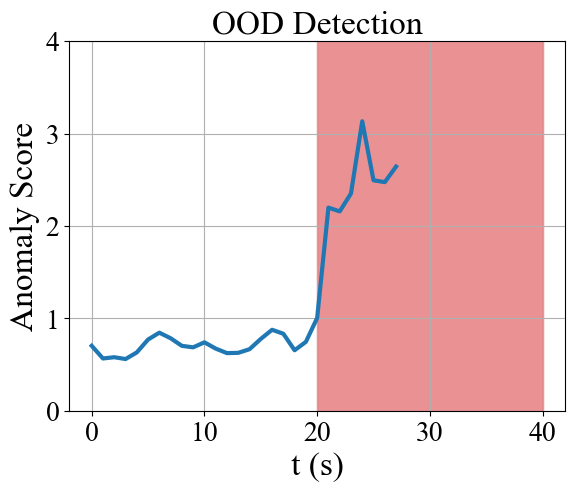

In [75]:
plt.figure()
ax = plt.gca()
plt.plot(reconstruction_errors, lw=3, color="tab:blue", alpha=1)
# ax.set_xlim(0,50)
ax.set_ylim(0,4)
ax.grid()
ax.set_xlabel("t (s)")
ax.set_ylabel("Anomaly Score")
ax.set_title("OOD Detection")
ax.fill_between(failure_times, [-100, -100], [100,100],color="tab:red", label="ood", alpha=alpha)
# ax.legend()

In [ ]:
fig, ax = plt.subplots()